In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
testDF = df_encoded.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns
scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [26]:
# Define the Encoder model with reduced complexity and dropout
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Define the Decoder model with reduced complexity and dropout
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(x)

In [27]:
# Define input dimensions
input_dim = x_train.shape[1]
encoding_dim = 8

# Load the trained autoencoder models
encoder_model_file = './models/encoder2.pth'
decoder_model_file = './models/decoder2.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(input_dim, encoding_dim).to(device)
decoder = Decoder(encoding_dim, input_dim).to(device)
encoder.load_state_dict(torch.load(encoder_model_file))
decoder.load_state_dict(torch.load(decoder_model_file))
encoder.eval()
decoder.eval()

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoder, decoder).to(device)

C:\Users\ROG\AppData\Local\Temp/ipykernel_24248/3703475411.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_model_file))
C:\Us

In [28]:
# Calculate reconstruction errors for training data
with torch.no_grad():
    reconstructed_train = autoencoder(torch.tensor(x_train.values, dtype=torch.float32).to(device)).cpu().numpy()
reconstruction_error_train = np.mean(np.square(x_train.values - reconstructed_train), axis=1)

# Calculate reconstruction errors for test data
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(x_test.values, dtype=torch.float32).to(device)).cpu().numpy()
reconstruction_error_test = np.mean(np.square(x_test.values - reconstructed_test), axis=1)

In [29]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [30]:
# Add reconstruction error as an additional feature
x_train_augmented = np.hstack((x_train.values, reconstruction_error_train.reshape(-1, 1)))
x_test_augmented = np.hstack((x_test.values, reconstruction_error_test.reshape(-1, 1)))

# Train the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(x_train_augmented, y_train)

# Make predictions
y_pred = mlp.predict(x_test_augmented)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.47%


In [48]:
def error_correction_function(mlp, autoencoder, x, threshold=5.0, bias_factor=0.1):
    # Calculate reconstruction error
    with torch.no_grad():
        encoded = autoencoder.encoder(torch.tensor(x, dtype=torch.float32).to(device))
        reconstructed = autoencoder.decoder(encoded).cpu().numpy()
    reconstruction_error = np.mean(np.square(x - reconstructed), axis=1)
    
    # Add reconstruction error as an additional feature
    x_augmented = np.hstack((x, reconstruction_error.reshape(-1, 1)))
    
    # Make predictions with the MLP model
    y_pred_proba = mlp.predict_proba(x_augmented)[:, 1]  # Get the probability of the positive class
    
    # Adjust predictions based on reconstruction error
    high_error_indices = np.where(reconstruction_error > (threshold / 100))[0]
    y_pred_proba_corrected = y_pred_proba.copy()
    y_pred_proba_corrected[high_error_indices] += bias_factor  # Add bias to high error predictions
    y_pred_proba_corrected = np.clip(y_pred_proba_corrected, 0, 1)  # Ensure probabilities are within [0, 1]
    
    # Convert probabilities to binary predictions
    y_pred_corrected = (y_pred_proba_corrected > 0.5).astype(int)
    
    return y_pred_corrected

# Use the error correction function to make predictions
y_pred_corrected = error_correction_function(mlp, autoencoder, x_test.values)

# Calculate corrected accuracy
corrected_accuracy = accuracy_score(y_test, y_pred_corrected)
print(f"Corrected Accuracy: {corrected_accuracy * 100:.2f}%")

Corrected Accuracy: 97.36%


In [32]:
import torch

# Define the original MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

# Load the original MLP model
mlp_model_file = './models/mlp_model_resampled_0.1.pth'
input_dim = x_train.shape[1]
original_mlp = MLP(input_dim).to(device)
original_mlp.load_state_dict(torch.load(mlp_model_file))
original_mlp.eval()

# Evaluate the original MLP model
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
    y_pred_original = original_mlp(x_test_tensor).cpu().numpy().flatten()
    y_pred_original = (y_pred_original > 0.5).astype(int)  # Convert to binary predictions

# Calculate accuracy
original_accuracy = accuracy_score(y_test, y_pred_original)
print(f"Original MLP Accuracy: {original_accuracy * 100:.2f}%")

Original MLP Accuracy: 97.07%


C:\Users\ROG\AppData\Local\Temp/ipykernel_24248/2817485887.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_mlp.load_state_dict(torch.load(mlp_model_file))


In [33]:
import torch
import numpy as np

# Calculate reconstruction errors for test data
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(x_test.values, dtype=torch.float32).to(device)).cpu().numpy()
reconstruction_error_test = np.mean(np.square(x_test.values - reconstructed_test), axis=1)

In [34]:
# Evaluate the original MLP model
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
    y_pred_original = original_mlp(x_test_tensor).cpu().numpy().flatten()
    y_pred_original = (y_pred_original > 0.5).astype(int)  # Convert to binary predictions

# Calculate accuracy
original_accuracy = accuracy_score(y_test, y_pred_original)
print(f"Original MLP Accuracy: {original_accuracy * 100:.2f}%")

# Identify wrong predictions
wrong_prediction_indices = np.where(y_pred_original != y_test.values)[0]

Original MLP Accuracy: 97.07%


In [38]:
# Calculate mean reconstruction error for wrong predictions
wrong_prediction_reconstruction_errors = reconstruction_error_test[wrong_prediction_indices]
mean_wrong_error = np.mean(wrong_prediction_reconstruction_errors)
std_wrong_error = np.std(wrong_prediction_reconstruction_errors)

# Calculate mean reconstruction error for correct predictions
correct_prediction_indices = np.where(y_pred_original == y_test.values)[0]
correct_prediction_reconstruction_errors = reconstruction_error_test[correct_prediction_indices]
mean_correct_error = np.mean(correct_prediction_reconstruction_errors)
std_correct_error = np.std(correct_prediction_reconstruction_errors)

print(f"Mean Reconstruction Error for Wrong Predictions: {mean_wrong_error * 100:.2f}%")
print(f"Standard Deviation of Reconstruction Error for Wrong Predictions: {std_wrong_error * 100:.2f}%")
print(f"Mean Reconstruction Error for Correct Predictions: {mean_correct_error * 100:.2f}%")
print(f"Standard Deviation of Reconstruction Error for Correct Predictions: {std_correct_error * 100:.2f}%")

# Calculate the average reconstruction error
average_reconstruction_error = np.mean(reconstruction_error_test)

# Identify correct predictions with reconstruction error above the average
correct_high_error_indices = correct_prediction_indices[correct_prediction_reconstruction_errors > average_reconstruction_error]

# Count the number of correct predictions with high reconstruction error
num_correct_high_error = len(correct_high_error_indices)

# Total number of predictions made
total_predictions = len(y_test)

# Total correct predictions
total_correct = len(correct_prediction_indices)

# Total wrong predictions
total_wrong = len(wrong_prediction_indices)

# Number of wrong predictions below average reconstruction error
num_wrong_below_avg = np.sum(wrong_prediction_reconstruction_errors <= average_reconstruction_error)

# Number of wrong predictions above average reconstruction error
num_wrong_above_avg = np.sum(wrong_prediction_reconstruction_errors > average_reconstruction_error)

print(f"Number of correct predictions with reconstruction error above the average: {num_correct_high_error}")
print(f"Total number of predictions made: {total_predictions}")
print(f"Total correct predictions: {total_correct}")
print(f"Total wrong predictions: {total_wrong}")
print(f"Number of wrong predictions below average reconstruction error: {num_wrong_below_avg}")
print(f"Number of wrong predictions above average reconstruction error: {num_wrong_above_avg}")

Mean Reconstruction Error for Wrong Predictions: 5.18%
Standard Deviation of Reconstruction Error for Wrong Predictions: 10.98%
Mean Reconstruction Error for Correct Predictions: 3.53%
Standard Deviation of Reconstruction Error for Correct Predictions: 12.17%
Number of correct predictions with reconstruction error above the average: 4179
Total number of predictions made: 20000
Total correct predictions: 19414
Total wrong predictions: 586
Number of wrong predictions below average reconstruction error: 388
Number of wrong predictions above average reconstruction error: 198


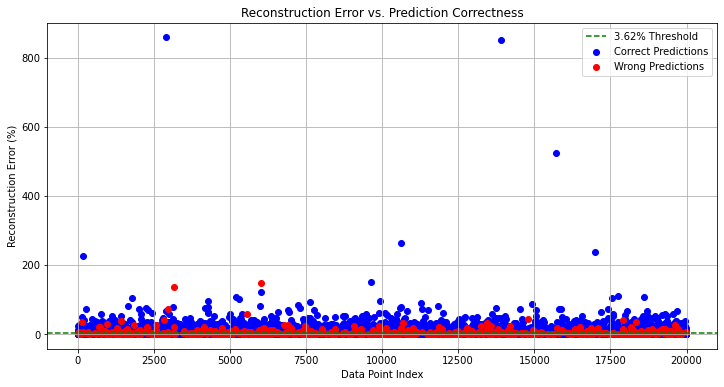

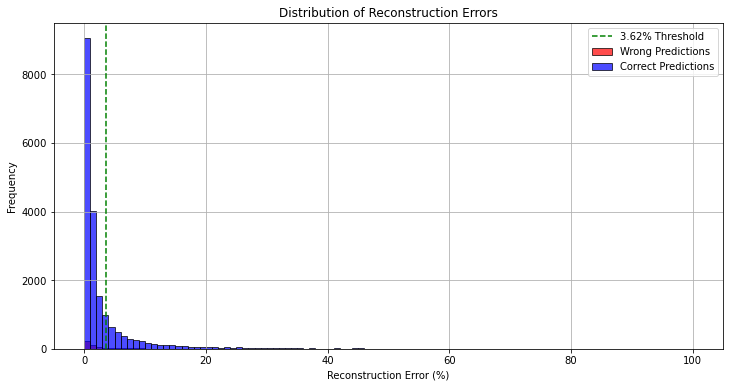

In [36]:
# Scatter plot of reconstruction error vs. prediction correctness
plt.figure(figsize=(12, 6))
plt.scatter(correct_prediction_indices, correct_prediction_reconstruction_errors * 100, color='blue', label='Correct Predictions')
plt.scatter(wrong_prediction_indices, wrong_prediction_reconstruction_errors * 100, color='red', label='Wrong Predictions')
plt.axhline(y=3.62, color='green', linestyle='--', label='3.62% Threshold')
plt.title('Reconstruction Error vs. Prediction Correctness')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error (%)')
plt.legend()
plt.grid(True)
plt.show()

# Histogram of reconstruction errors for wrong predictions
plt.figure(figsize=(12, 6))
bins = np.arange(0, 101, 1)  # From 0% to 100% in intervals of 1%
plt.hist(wrong_prediction_reconstruction_errors * 100, bins=bins, edgecolor='black', alpha=0.7, color='red', label='Wrong Predictions')
plt.hist(correct_prediction_reconstruction_errors * 100, bins=bins, edgecolor='black', alpha=0.7, color='blue', label='Correct Predictions')
plt.axvline(x=3.62, color='green', linestyle='--', label='3.62% Threshold')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()